In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp
import networkx as nx

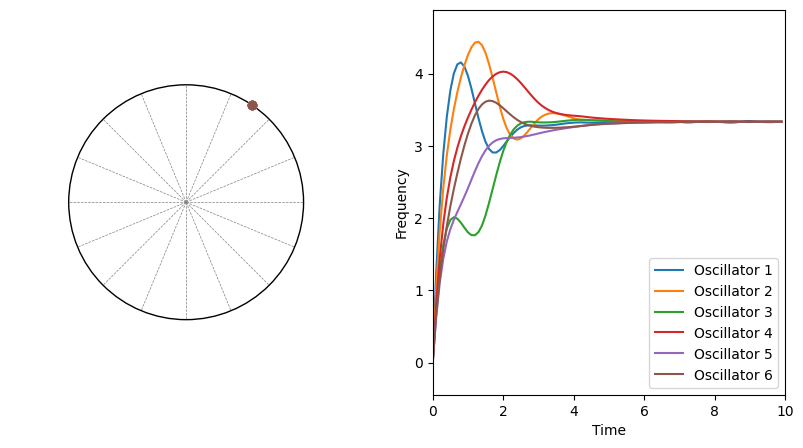

In [6]:



# Parameters
N = 6  # Number of oscillators
A = 0.3  # Coupling strength
m = 0.1  # Uniform inertia
d = 0.3  # Uniform damping
P = 1.0  # Uniform power injection

theta0 = np.random.uniform(0, 2 * np.pi, N)  # Initial positions
omega = np.random.uniform(-0.1, 0.1, N)  # Natural frequencies
total_time = 10  # Total simulation time
time_step = 0.1  # Time increment for the animation

# Define the adjacency matrix for a complete graph
#adjacency_matrix = np.ones((N, N)) - np.eye(N)


edges = [(0, 1), (0,2), (2, 1), (1, 5), (0,4), (3, 0)]
G = nx.from_edgelist(edges)
adjacency_matrix = nx.adjacency_matrix(G)





# Define the oscillator dynamics
def update_dynamics(t, y):
    theta = y[:N]
    dtheta_dt = y[N:]
    ddtheta_dt = np.zeros(N)
    for i in range(N):
        coupling_term = sum(
            adjacency_matrix[i, j] * np.sin(theta[j] - theta[i]) for j in range(N)
        )
        ddtheta_dt[i] = (P - d * dtheta_dt[i] + A * coupling_term) / m
    return np.concatenate([dtheta_dt, ddtheta_dt])

# Solve the ODE
y0 = np.concatenate([theta0, np.zeros(N)])  # Initial [theta, dtheta/dt]
t_eval = np.arange(0, total_time, time_step)
solution = solve_ivp(update_dynamics, [0, total_time], y0, t_eval=t_eval)
theta_solution = solution.y[:N]  # Extract theta over time
frequency_solution = solution.y[N:]  # Extract frequencies over time



# Initialize the figure and axes
fig, (ax_circle, ax_freq) = plt.subplots(1, 2, figsize=(10, 5))
ax_circle.set_xlim(-1.5, 1.5)
ax_circle.set_ylim(-1.5, 1.5)
ax_circle.set_aspect("equal")
ax_circle.axis('off')

# Draw the unit circle
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='-')
ax_circle.add_artist(circle)

# Number of radial gridlines
num_radial_lines = 16

# Add radial gridlines
angles = np.linspace(0, 2 * np.pi, num_radial_lines, endpoint=False)
for angle in angles:
    x = [0, np.cos(angle)]  # From origin to circumference
    y = [0, np.sin(angle)]
    ax_circle.plot(x, y, color='gray', linestyle='--', linewidth=0.5)  # Dashed gridline

# Initialize the oscillators (points on the circle)
oscillators = [ax_circle.plot([], [], "o")[0] for _ in range(N)]


# Compute the range of frequencies with a buffer
freq_min = np.min(frequency_solution)
freq_max = np.max(frequency_solution)
buffer = 0.1 * (freq_max - freq_min)  # 10% buffer




# Set up the frequency plot
ax_freq.set_xlim(0, total_time)
ax_freq.set_ylim(freq_min - buffer, freq_max + buffer)
#ax_freq.set_ylim(np.min(frequency_solution), np.max(frequency_solution))
#ax_freq.set_title("Frequencies of Oscillators Over Time")
ax_freq.set_xlabel("Time")
ax_freq.set_ylabel("Frequency")
frequency_lines = [ax_freq.plot([], [], label=f'Oscillator {i+1}')[0] for i in range(N)]
ax_freq.legend(loc="lower right")

# Animation function
def animate(frame):
    # Update circle positions
    theta = theta_solution[:, frame]
    x = np.cos(theta)
    y = np.sin(theta)
    for i, oscillator in enumerate(oscillators):
        oscillator.set_data([x[i]], [y[i]])
    
    # Update frequency plot
    time_up_to_now = t_eval[:frame + 1]
    for i, line in enumerate(frequency_lines):
        line.set_data(time_up_to_now, frequency_solution[i, :frame + 1])
    
    return oscillators + frequency_lines

# Create the animation
frames = len(t_eval)
ani = FuncAnimation(fig, animate, frames=frames, interval=5000, blit=True)

# Save the animation as MP4
ani.save('uniform_oscillators.mp4', writer='ffmpeg', fps=30)

# Show the animation
plt.show()


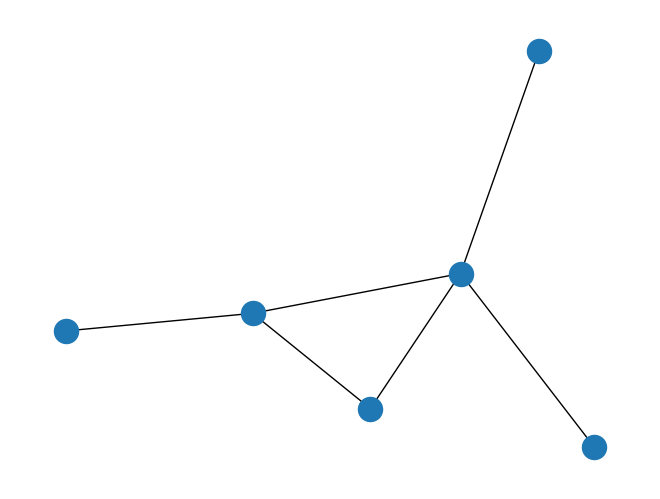

In [7]:
nx.draw(G)

In [9]:
frequency_solution[-1]

array([0.        , 0.66976395, 1.1768788 , 1.57125967, 1.89151283,
       2.16392182, 2.40376819, 2.62248981, 2.82399889, 3.00639035,
       3.16812628, 3.30823021, 3.42366467, 3.51178334, 3.57315989,
       3.6106494 , 3.62517522, 3.61893326, 3.59620713, 3.56217872,
       3.52087327, 3.47698232, 3.43400455, 3.39416916, 3.35884529,
       3.3293059 , 3.30589781, 3.28790581, 3.27416455, 3.26440289,
       3.25758709, 3.25293746, 3.24999605, 3.24861286, 3.24857966,
       3.24951726, 3.25119432, 3.25354382, 3.2566631 , 3.2604604 ,
       3.26457762, 3.26905065, 3.2738423 , 3.27883584, 3.28383501,
       3.28856402, 3.29275516, 3.29655725, 3.29994931, 3.30291112,
       3.30547095, 3.30770558, 3.30974027, 3.31174878, 3.31379148,
       3.31569935, 3.31748854, 3.31916803, 3.32073435, 3.32217159,
       3.32345142, 3.32453306, 3.32536329, 3.32587649, 3.32599455,
       3.32565956, 3.32525479, 3.3252323 , 3.32583588, 3.32710069,
       3.32885331, 3.3307117 , 3.33208522, 3.33226292, 3.33171

In [10]:
# Synchronization check
def is_synchronized(y, threshold=0.05):
    N = len(y) // 2
    omega = y[N:]

    for i in range(N):
        for j in range(i + 1, N):
            if abs(omega[i] - omega[j]) >= threshold:
                return False
    return True


In [14]:
is_synchronized(solution.y[:, -1])

True